In [1]:
from json import load
import random
import re

In [3]:
with open('banglaNames.json') as file:
    names = load(file)
outfile.close()

In [9]:
type(names)

dict

In [10]:
names.keys()

dict_keys(['male', 'female'])

In [11]:
names['male'][:10]

['Aabhas  আভাস',
 'Aabhat  আভাত',
 'Aabheer  আভীর',
 'Aabir  আবীর ',
 'Aacharya  আচার্য',
 'Aachman  আচমন',
 'Aadamya  আদম্য',
 'Aadarsh  আদর্শ',
 'Aadarsha  আদর্শ',
 'Aadavan  আদবন']

In [12]:
names['female'][:10]

['Aabha  আভা',
 'Aabharana  আভরণ',
 'Aabheri  আভেরী',
 'Aabinta  আবিন্তা ',
 'Aadanya  অদান্য',
 'Aadarshini  আদর্শিনী',
 'Aadhini  অধিনী',
 'Aadhira  অধীরা',
 'Aadhrika  আধ্রিকা',
 'Aadhya  আধ্যা']

In [7]:
allNames =  [ ((re.sub(r'[^a-zA-Z]', '', names)).lower(),1) for names in names['male']]
allNames.extend([ ((re.sub(r'[^a-zA-Z]', '', names)).lower(),0) for names in names['female']])

In [8]:
len(allNames)

49593

In [13]:
allNames = list(set(allNames))

In [14]:
len(allNames)

42294

In [15]:
random.shuffle(allNames)

In [16]:
allNames = [(name,gender) for name,gender in allNames if len(name)>1]

In [17]:
len(allNames)

42292

In [21]:
names = [name for name,_ in allNames]
genders = [gender for _,gender in allNames]

In [18]:
from collections import Counter

In [41]:
genderCounter = Counter(genders)

In [42]:
import matplotlib.pyplot as plt

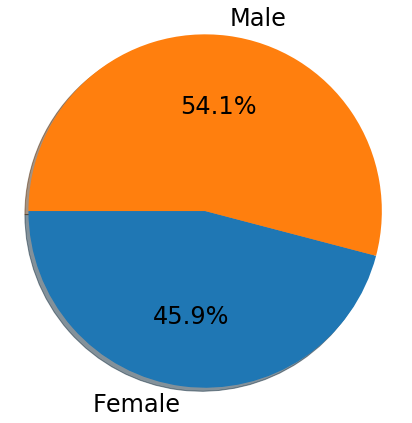

In [45]:
labels = ['Female' if i==0 else 'Male' for i in genderCounter.keys()]
value = [i for i in genderCounter.values()]

patches,texts,autotexts=plt.pie(value, labels=labels, autopct='%1.1f%%',shadow=True, startangle=180)

for i in range(len(labels)):
    texts[i].set_fontsize(24)
    autotexts[i].set_fontsize(24)
plt.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()

In [24]:
print(names[:5],genders[:5])

['tithi', 'fawzahfawza', 'abdulsamee', 'atharav', 'nishira'] [0, 0, 1, 1, 0]
